In [1]:
import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("train.csv")

descriptions = data.iloc[:, 1].values.tolist()
names = data.iloc[:, 0].values.tolist()

In [3]:
print(names[4])

PUFF SLEEVE DRESS WITH PLEATS TRF


In [4]:
word_names = []
word_descriptions = []

for name in names:
    word_names += name.split(' ')

for description in descriptions:
    html_less = description.split('<')[0]
    word_descriptions += html_less.split(' ')

word_names = set(word_names)   
word_descriptions = set(word_descriptions)  
    

In [5]:
print(len(word_names))  # tokens for create names -> pass to numerical and hot-encoding
print(len(word_descriptions))

4487
11218


In [6]:
class tokenizer:
    

    def __init__(self):
        self.token = {}
        self.word  = {}
        vocab_size = 0
        
    def fit(self, vocabulary):
        n = 1
        for word in vocabulary:
            self.token[word] = n
            self.word[n] = word
            n += 1
        self.vocab_size = n
    
    """
    def encode(self, s):
    s = tf.compat.as_text(s)
    tokens = self._tokenizer.tokenize(s)
    tokens = _prepare_tokens_for_encode(tokens)
    ids = []
    for token in tokens:
      ids.extend(self._token_to_ids(token))
    return text_encoder.pad_incr(ids)

    """
    
    def encode(self, words):
        tokens = []
        
        words = tf.compat.as_text(words)
        
        for word in words.split(' '):
            if word in self.token:
                tokens += [self.token[word]]
        return tokens
        
        
    def decode(self, tokens):
        words = ""
        for token in tokens:
            words += self.word[token] + " "
            
        return words.strip()
        
        
    

In [7]:
tokenizer_en = tokenizer()
tokenizer_en.fit(word_names)

tokenizer_pt = tokenizer()
tokenizer_pt.fit(word_descriptions)

In [8]:
sample_string = 'PUFF SLEEVE DRESS WITH PLEATS TRF PUFF'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [3277, 3091, 1196, 648, 2457, 2214, 3277]
The original string: PUFF SLEEVE DRESS WITH PLEATS TRF PUFF


The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary.

In [9]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

3277 ----> PUFF
3091 ----> SLEEVE
1196 ----> DRESS
648 ----> WITH
2457 ----> PLEATS
2214 ----> TRF
3277 ----> PUFF


In [10]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

Add a start and end token to the input and target. 

In [11]:
def encode(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

You want to use `Dataset.map` to apply this function to each element of the dataset.  `Dataset.map` runs in graph mode.

* Graph tensors do not have a value. 
* In graph mode you can only use TensorFlow Ops and functions. 

So you can't `.map` this function directly: You need to wrap it in a `tf.py_function`. The `tf.py_function` will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

In [12]:
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

Note: To keep this example small and relatively fast, drop examples with a length of over 40 tokens.

In [13]:
MAX_LENGTH = 100

In [14]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [15]:
train_x = descriptions
train_y = names

valid_x = descriptions[int(len(descriptions)/2):]
valid_y = names[int(len(names)/2):]


train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

In [16]:
train_dataset = train_data.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = valid_data.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [17]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 33), dtype=int64, numpy=
 array([[11219,  2966,  5710, ...,     0,     0,     0],
        [11219,  5335,  9770, ...,     0,     0,     0],
        [11219,  4542,  2247, ...,     0,     0,     0],
        ...,
        [11219,  1592,   124, ...,     0,     0,     0],
        [11219,  1464,  9770, ...,     0,     0,     0],
        [11219,  2966,  8059, ...,     0,     0,     0]], dtype=int64)>,
 <tf.Tensor: shape=(64, 8), dtype=int64, numpy=
 array([[4488, 2491, 3735, 4489,    0,    0,    0,    0],
        [4488,  478,  938, 2158, 3110, 4489,    0,    0],
        [4488, 1190, 3004, 4489,    0,    0,    0,    0],
        [4488, 1682, 2158, 3110, 4489,    0,    0,    0],
        [4488,  377, 2785, 3110, 4489,    0,    0,    0],
        [4488, 3318, 3152, 3004, 4489,    0,    0,    0],
        [4488, 4354, 3876,  648, 3436, 4489,    0,    0],
        [4488, 2158, 3004,  648, 3983, 4489,    0,    0],
        [4488, 2594, 2158, 3110, 4489,    0,    0,    0],
        [4

## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [18]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [19]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


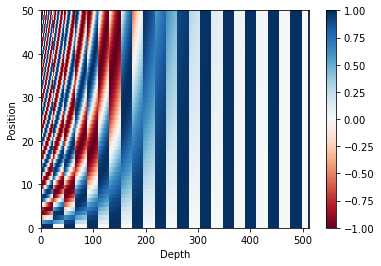

In [20]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [21]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [22]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [23]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [24]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [25]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [26]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [27]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [28]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [29]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together.

In [30]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [31]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [32]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [33]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [34]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [35]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [36]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [37]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [38]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [39]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [40]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [41]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [42]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [43]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [44]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [45]:
num_layers = 6
d_model = 512
dff = 2048
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [46]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [47]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

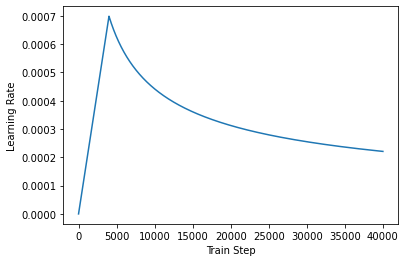

In [48]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [49]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [50]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))
  
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [51]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training and checkpointing

In [52]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [53]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [54]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
"""
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')
"""  
  

"\n# if a checkpoint exists, restore the latest checkpoint.\nif ckpt_manager.latest_checkpoint:\n  ckpt.restore(ckpt_manager.latest_checkpoint)\n  print ('Latest checkpoint restored!!')\n"

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

During training this example uses teacher-forcing (like in the [text generation tutorial](./text_generation.ipynb)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, *self-attention* allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [55]:
EPOCHS = 150

In [56]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

Portuguese is used as the input language and English is the target language.

In [57]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 8.5242 Accuracy 0.0000
Epoch 1 Batch 50 Loss 7.6409 Accuracy 0.1459
Epoch 1 Batch 100 Loss 7.1173 Accuracy 0.1802
Epoch 1 Batch 150 Loss 6.8381 Accuracy 0.1903
Epoch 1 Batch 200 Loss 6.6104 Accuracy 0.1951
Epoch 1 Batch 250 Loss 6.4015 Accuracy 0.2017
Epoch 1 Batch 300 Loss 6.1933 Accuracy 0.2118
Epoch 1 Batch 350 Loss 5.9932 Accuracy 0.2237
Epoch 1 Batch 400 Loss 5.8130 Accuracy 0.2353
Epoch 1 Batch 450 Loss 5.6462 Accuracy 0.2468
Epoch 1 Batch 500 Loss 5.4968 Accuracy 0.2577
Epoch 1 Loss 5.4357 Accuracy 0.2621
Time taken for 1 epoch: 177.79771161079407 secs

Epoch 2 Batch 0 Loss 3.8508 Accuracy 0.3946
Epoch 2 Batch 50 Loss 3.3985 Accuracy 0.4257
Epoch 2 Batch 100 Loss 3.3494 Accuracy 0.4271
Epoch 2 Batch 150 Loss 3.3712 Accuracy 0.4218
Epoch 2 Batch 200 Loss 3.3963 Accuracy 0.4167
Epoch 2 Batch 250 Loss 3.4251 Accuracy 0.4133
Epoch 2 Batch 300 Loss 3.4223 Accuracy 0.4133
Epoch 2 Batch 350 Loss 3.4135 Accuracy 0.4147
Epoch 2 Batch 400 Loss 3.3916 Accuracy 0.4169
E

Epoch 14 Batch 450 Loss 1.4703 Accuracy 0.6465
Epoch 14 Batch 500 Loss 1.4711 Accuracy 0.6470
Epoch 14 Loss 1.4700 Accuracy 0.6472
Time taken for 1 epoch: 153.37371277809143 secs

Epoch 15 Batch 0 Loss 1.4094 Accuracy 0.6169
Epoch 15 Batch 50 Loss 1.4009 Accuracy 0.6441
Epoch 15 Batch 100 Loss 1.4054 Accuracy 0.6454
Epoch 15 Batch 150 Loss 1.3850 Accuracy 0.6496
Epoch 15 Batch 200 Loss 1.3727 Accuracy 0.6540
Epoch 15 Batch 250 Loss 1.3725 Accuracy 0.6561
Epoch 15 Batch 300 Loss 1.3663 Accuracy 0.6590
Epoch 15 Batch 350 Loss 1.3642 Accuracy 0.6612
Epoch 15 Batch 400 Loss 1.3626 Accuracy 0.6622
Epoch 15 Batch 450 Loss 1.3657 Accuracy 0.6625
Epoch 15 Batch 500 Loss 1.3701 Accuracy 0.6628
Saving checkpoint for epoch 15 at ./checkpoints/train\ckpt-3
Epoch 15 Loss 1.3713 Accuracy 0.6631
Time taken for 1 epoch: 160.2608814239502 secs

Epoch 16 Batch 0 Loss 1.1730 Accuracy 0.7003
Epoch 16 Batch 50 Loss 1.2940 Accuracy 0.6699
Epoch 16 Batch 100 Loss 1.3192 Accuracy 0.6626
Epoch 16 Batch 150 Los

Epoch 28 Batch 50 Loss 0.7768 Accuracy 0.7741
Epoch 28 Batch 100 Loss 0.7531 Accuracy 0.7811
Epoch 28 Batch 150 Loss 0.7371 Accuracy 0.7858
Epoch 28 Batch 200 Loss 0.7212 Accuracy 0.7916
Epoch 28 Batch 250 Loss 0.7111 Accuracy 0.7954
Epoch 28 Batch 300 Loss 0.7087 Accuracy 0.7968
Epoch 28 Batch 350 Loss 0.7083 Accuracy 0.7974
Epoch 28 Batch 400 Loss 0.7076 Accuracy 0.7983
Epoch 28 Batch 450 Loss 0.7095 Accuracy 0.7979
Epoch 28 Batch 500 Loss 0.7138 Accuracy 0.7976
Epoch 28 Loss 0.7168 Accuracy 0.7970
Time taken for 1 epoch: 161.55757689476013 secs

Epoch 29 Batch 0 Loss 0.6353 Accuracy 0.8066
Epoch 29 Batch 50 Loss 0.7396 Accuracy 0.7854
Epoch 29 Batch 100 Loss 0.7382 Accuracy 0.7844
Epoch 29 Batch 150 Loss 0.7200 Accuracy 0.7899
Epoch 29 Batch 200 Loss 0.7015 Accuracy 0.7959
Epoch 29 Batch 250 Loss 0.6846 Accuracy 0.8019
Epoch 29 Batch 300 Loss 0.6795 Accuracy 0.8040
Epoch 29 Batch 350 Loss 0.6793 Accuracy 0.8047
Epoch 29 Batch 400 Loss 0.6818 Accuracy 0.8046
Epoch 29 Batch 450 Loss 0

Epoch 41 Batch 300 Loss 0.4230 Accuracy 0.8727
Epoch 41 Batch 350 Loss 0.4249 Accuracy 0.8722
Epoch 41 Batch 400 Loss 0.4254 Accuracy 0.8724
Epoch 41 Batch 450 Loss 0.4282 Accuracy 0.8718
Epoch 41 Batch 500 Loss 0.4313 Accuracy 0.8712
Epoch 41 Loss 0.4336 Accuracy 0.8707
Time taken for 1 epoch: 154.3997871875763 secs

Epoch 42 Batch 0 Loss 0.4013 Accuracy 0.8794
Epoch 42 Batch 50 Loss 0.4547 Accuracy 0.8611
Epoch 42 Batch 100 Loss 0.4531 Accuracy 0.8619
Epoch 42 Batch 150 Loss 0.4358 Accuracy 0.8674
Epoch 42 Batch 200 Loss 0.4257 Accuracy 0.8709
Epoch 42 Batch 250 Loss 0.4161 Accuracy 0.8746
Epoch 42 Batch 300 Loss 0.4129 Accuracy 0.8758
Epoch 42 Batch 350 Loss 0.4134 Accuracy 0.8758
Epoch 42 Batch 400 Loss 0.4165 Accuracy 0.8754
Epoch 42 Batch 450 Loss 0.4175 Accuracy 0.8753
Epoch 42 Batch 500 Loss 0.4217 Accuracy 0.8743
Epoch 42 Loss 0.4228 Accuracy 0.8740
Time taken for 1 epoch: 158.03592705726624 secs

Epoch 43 Batch 0 Loss 0.4278 Accuracy 0.8495
Epoch 43 Batch 50 Loss 0.4399 Accur

Epoch 55 Batch 0 Loss 0.2067 Accuracy 0.9419
Epoch 55 Batch 50 Loss 0.3174 Accuracy 0.9040
Epoch 55 Batch 100 Loss 0.3221 Accuracy 0.9025
Epoch 55 Batch 150 Loss 0.3113 Accuracy 0.9050
Epoch 55 Batch 200 Loss 0.3031 Accuracy 0.9078
Epoch 55 Batch 250 Loss 0.2950 Accuracy 0.9100
Epoch 55 Batch 300 Loss 0.2926 Accuracy 0.9107
Epoch 55 Batch 350 Loss 0.2924 Accuracy 0.9111
Epoch 55 Batch 400 Loss 0.2928 Accuracy 0.9114
Epoch 55 Batch 450 Loss 0.2958 Accuracy 0.9109
Epoch 55 Batch 500 Loss 0.2984 Accuracy 0.9104
Saving checkpoint for epoch 55 at ./checkpoints/train\ckpt-11
Epoch 55 Loss 0.2997 Accuracy 0.9103
Time taken for 1 epoch: 163.48155522346497 secs

Epoch 56 Batch 0 Loss 0.4259 Accuracy 0.8706
Epoch 56 Batch 50 Loss 0.3093 Accuracy 0.9040
Epoch 56 Batch 100 Loss 0.3098 Accuracy 0.9040
Epoch 56 Batch 150 Loss 0.3052 Accuracy 0.9062
Epoch 56 Batch 200 Loss 0.2965 Accuracy 0.9089
Epoch 56 Batch 250 Loss 0.2915 Accuracy 0.9110
Epoch 56 Batch 300 Loss 0.2902 Accuracy 0.9121
Epoch 56 Bat

Epoch 68 Batch 250 Loss 0.2304 Accuracy 0.9304
Epoch 68 Batch 300 Loss 0.2266 Accuracy 0.9318
Epoch 68 Batch 350 Loss 0.2269 Accuracy 0.9321
Epoch 68 Batch 400 Loss 0.2293 Accuracy 0.9318
Epoch 68 Batch 450 Loss 0.2301 Accuracy 0.9317
Epoch 68 Batch 500 Loss 0.2321 Accuracy 0.9314
Epoch 68 Loss 0.2325 Accuracy 0.9314
Time taken for 1 epoch: 166.60879826545715 secs

Epoch 69 Batch 0 Loss 0.2599 Accuracy 0.9226
Epoch 69 Batch 50 Loss 0.2414 Accuracy 0.9286
Epoch 69 Batch 100 Loss 0.2362 Accuracy 0.9286
Epoch 69 Batch 150 Loss 0.2329 Accuracy 0.9295
Epoch 69 Batch 200 Loss 0.2270 Accuracy 0.9317
Epoch 69 Batch 250 Loss 0.2220 Accuracy 0.9338
Epoch 69 Batch 300 Loss 0.2198 Accuracy 0.9348
Epoch 69 Batch 350 Loss 0.2197 Accuracy 0.9347
Epoch 69 Batch 400 Loss 0.2204 Accuracy 0.9345
Epoch 69 Batch 450 Loss 0.2221 Accuracy 0.9343
Epoch 69 Batch 500 Loss 0.2247 Accuracy 0.9336
Epoch 69 Loss 0.2250 Accuracy 0.9336
Time taken for 1 epoch: 158.0664038658142 secs

Epoch 70 Batch 0 Loss 0.2538 Accu

Epoch 81 Batch 500 Loss 0.1912 Accuracy 0.9443
Epoch 81 Loss 0.1922 Accuracy 0.9442
Time taken for 1 epoch: 158.78654837608337 secs

Epoch 82 Batch 0 Loss 0.1687 Accuracy 0.9381
Epoch 82 Batch 50 Loss 0.2058 Accuracy 0.9388
Epoch 82 Batch 100 Loss 0.2047 Accuracy 0.9390
Epoch 82 Batch 150 Loss 0.1957 Accuracy 0.9410
Epoch 82 Batch 200 Loss 0.1901 Accuracy 0.9429
Epoch 82 Batch 250 Loss 0.1865 Accuracy 0.9448
Epoch 82 Batch 300 Loss 0.1845 Accuracy 0.9455
Epoch 82 Batch 350 Loss 0.1849 Accuracy 0.9455
Epoch 82 Batch 400 Loss 0.1860 Accuracy 0.9456
Epoch 82 Batch 450 Loss 0.1863 Accuracy 0.9456
Epoch 82 Batch 500 Loss 0.1885 Accuracy 0.9451
Epoch 82 Loss 0.1888 Accuracy 0.9450
Time taken for 1 epoch: 158.35846996307373 secs

Epoch 83 Batch 0 Loss 0.2141 Accuracy 0.9293
Epoch 83 Batch 50 Loss 0.1930 Accuracy 0.9426
Epoch 83 Batch 100 Loss 0.1914 Accuracy 0.9416
Epoch 83 Batch 150 Loss 0.1848 Accuracy 0.9436
Epoch 83 Batch 200 Loss 0.1817 Accuracy 0.9452
Epoch 83 Batch 250 Loss 0.1789 Accu

Epoch 95 Batch 200 Loss 0.1620 Accuracy 0.9517
Epoch 95 Batch 250 Loss 0.1602 Accuracy 0.9528
Epoch 95 Batch 300 Loss 0.1579 Accuracy 0.9535
Epoch 95 Batch 350 Loss 0.1567 Accuracy 0.9541
Epoch 95 Batch 400 Loss 0.1572 Accuracy 0.9542
Epoch 95 Batch 450 Loss 0.1579 Accuracy 0.9543
Epoch 95 Batch 500 Loss 0.1592 Accuracy 0.9540
Saving checkpoint for epoch 95 at ./checkpoints/train\ckpt-19
Epoch 95 Loss 0.1604 Accuracy 0.9538
Time taken for 1 epoch: 161.08275389671326 secs

Epoch 96 Batch 0 Loss 0.2272 Accuracy 0.9414
Epoch 96 Batch 50 Loss 0.1695 Accuracy 0.9493
Epoch 96 Batch 100 Loss 0.1640 Accuracy 0.9515
Epoch 96 Batch 150 Loss 0.1616 Accuracy 0.9517
Epoch 96 Batch 200 Loss 0.1595 Accuracy 0.9529
Epoch 96 Batch 250 Loss 0.1583 Accuracy 0.9535
Epoch 96 Batch 300 Loss 0.1564 Accuracy 0.9542
Epoch 96 Batch 350 Loss 0.1571 Accuracy 0.9542
Epoch 96 Batch 400 Loss 0.1577 Accuracy 0.9543
Epoch 96 Batch 450 Loss 0.1580 Accuracy 0.9544
Epoch 96 Batch 500 Loss 0.1587 Accuracy 0.9545
Epoch 96 

Epoch 108 Batch 350 Loss 0.1398 Accuracy 0.9595
Epoch 108 Batch 400 Loss 0.1403 Accuracy 0.9594
Epoch 108 Batch 450 Loss 0.1415 Accuracy 0.9593
Epoch 108 Batch 500 Loss 0.1427 Accuracy 0.9591
Epoch 108 Loss 0.1435 Accuracy 0.9590
Time taken for 1 epoch: 153.86160397529602 secs

Epoch 109 Batch 0 Loss 0.1703 Accuracy 0.9626
Epoch 109 Batch 50 Loss 0.1599 Accuracy 0.9531
Epoch 109 Batch 100 Loss 0.1538 Accuracy 0.9544
Epoch 109 Batch 150 Loss 0.1501 Accuracy 0.9556
Epoch 109 Batch 200 Loss 0.1452 Accuracy 0.9575
Epoch 109 Batch 250 Loss 0.1417 Accuracy 0.9587
Epoch 109 Batch 300 Loss 0.1410 Accuracy 0.9589
Epoch 109 Batch 350 Loss 0.1410 Accuracy 0.9591
Epoch 109 Batch 400 Loss 0.1419 Accuracy 0.9591
Epoch 109 Batch 450 Loss 0.1420 Accuracy 0.9594
Epoch 109 Batch 500 Loss 0.1434 Accuracy 0.9592
Epoch 109 Loss 0.1439 Accuracy 0.9592
Time taken for 1 epoch: 153.01341676712036 secs

Epoch 110 Batch 0 Loss 0.1259 Accuracy 0.9652
Epoch 110 Batch 50 Loss 0.1437 Accuracy 0.9565
Epoch 110 Batch 

Epoch 121 Batch 450 Loss 0.1279 Accuracy 0.9633
Epoch 121 Batch 500 Loss 0.1294 Accuracy 0.9631
Epoch 121 Loss 0.1299 Accuracy 0.9630
Time taken for 1 epoch: 172.97605085372925 secs

Epoch 122 Batch 0 Loss 0.1140 Accuracy 0.9592
Epoch 122 Batch 50 Loss 0.1335 Accuracy 0.9589
Epoch 122 Batch 100 Loss 0.1379 Accuracy 0.9590
Epoch 122 Batch 150 Loss 0.1341 Accuracy 0.9605
Epoch 122 Batch 200 Loss 0.1291 Accuracy 0.9624
Epoch 122 Batch 250 Loss 0.1276 Accuracy 0.9633
Epoch 122 Batch 300 Loss 0.1254 Accuracy 0.9637
Epoch 122 Batch 350 Loss 0.1260 Accuracy 0.9638
Epoch 122 Batch 400 Loss 0.1257 Accuracy 0.9642
Epoch 122 Batch 450 Loss 0.1263 Accuracy 0.9642
Epoch 122 Batch 500 Loss 0.1270 Accuracy 0.9640
Epoch 122 Loss 0.1276 Accuracy 0.9639
Time taken for 1 epoch: 179.40934443473816 secs

Epoch 123 Batch 0 Loss 0.1814 Accuracy 0.9558
Epoch 123 Batch 50 Loss 0.1338 Accuracy 0.9605
Epoch 123 Batch 100 Loss 0.1369 Accuracy 0.9607
Epoch 123 Batch 150 Loss 0.1328 Accuracy 0.9616
Epoch 123 Batch 

Epoch 135 Batch 0 Loss 0.1784 Accuracy 0.9331
Epoch 135 Batch 50 Loss 0.1244 Accuracy 0.9631
Epoch 135 Batch 100 Loss 0.1211 Accuracy 0.9650
Epoch 135 Batch 150 Loss 0.1205 Accuracy 0.9653
Epoch 135 Batch 200 Loss 0.1194 Accuracy 0.9659
Epoch 135 Batch 250 Loss 0.1163 Accuracy 0.9666
Epoch 135 Batch 300 Loss 0.1160 Accuracy 0.9670
Epoch 135 Batch 350 Loss 0.1161 Accuracy 0.9671
Epoch 135 Batch 400 Loss 0.1177 Accuracy 0.9669
Epoch 135 Batch 450 Loss 0.1184 Accuracy 0.9667
Epoch 135 Batch 500 Loss 0.1190 Accuracy 0.9666
Saving checkpoint for epoch 135 at ./checkpoints/train\ckpt-27
Epoch 135 Loss 0.1193 Accuracy 0.9666
Time taken for 1 epoch: 165.35190343856812 secs

Epoch 136 Batch 0 Loss 0.1550 Accuracy 0.9609
Epoch 136 Batch 50 Loss 0.1295 Accuracy 0.9633
Epoch 136 Batch 100 Loss 0.1262 Accuracy 0.9640
Epoch 136 Batch 150 Loss 0.1228 Accuracy 0.9648
Epoch 136 Batch 200 Loss 0.1193 Accuracy 0.9658
Epoch 136 Batch 250 Loss 0.1160 Accuracy 0.9670
Epoch 136 Batch 300 Loss 0.1165 Accuracy

Epoch 148 Batch 100 Loss 0.1197 Accuracy 0.9654
Epoch 148 Batch 150 Loss 0.1163 Accuracy 0.9662
Epoch 148 Batch 200 Loss 0.1125 Accuracy 0.9675
Epoch 148 Batch 250 Loss 0.1100 Accuracy 0.9686
Epoch 148 Batch 300 Loss 0.1098 Accuracy 0.9687
Epoch 148 Batch 350 Loss 0.1088 Accuracy 0.9690
Epoch 148 Batch 400 Loss 0.1080 Accuracy 0.9693
Epoch 148 Batch 450 Loss 0.1087 Accuracy 0.9693
Epoch 148 Batch 500 Loss 0.1097 Accuracy 0.9691
Epoch 148 Loss 0.1103 Accuracy 0.9689
Time taken for 1 epoch: 154.21997618675232 secs

Epoch 149 Batch 0 Loss 0.1280 Accuracy 0.9582
Epoch 149 Batch 50 Loss 0.1195 Accuracy 0.9657
Epoch 149 Batch 100 Loss 0.1200 Accuracy 0.9645
Epoch 149 Batch 150 Loss 0.1169 Accuracy 0.9657
Epoch 149 Batch 200 Loss 0.1134 Accuracy 0.9669
Epoch 149 Batch 250 Loss 0.1114 Accuracy 0.9676
Epoch 149 Batch 300 Loss 0.1101 Accuracy 0.9683
Epoch 149 Batch 350 Loss 0.1093 Accuracy 0.9688
Epoch 149 Batch 400 Loss 0.1095 Accuracy 0.9689
Epoch 149 Batch 450 Loss 0.1101 Accuracy 0.9688
Epoc

In [58]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [59]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_pt.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [60]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  predicted_sentence = tokenizer_en.decode([i for i in result.numpy()
                                            if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [61]:
def generate_submision(descriptions):
    f = open("myfile.txt", "w")
    f.write("name\n")
    
    for sentence in descriptions:
    
        result, attention_weights = evaluate(sentence)
        predicted_sentence = tokenizer_en.decode([i for i in result.numpy()
                                                if i < tokenizer_en.vocab_size])  

    
        f.write(predicted_sentence + "\n")
    f.close()
    
    
  

In [62]:


test = pd.read_csv("test_descriptions.csv")

lines = test.values.ravel()

generate_submision(lines)



In [63]:
import matplotlib.pyplot as plt

ValueError: x and y must have same first dimension, but have shapes (6,) and (11,)

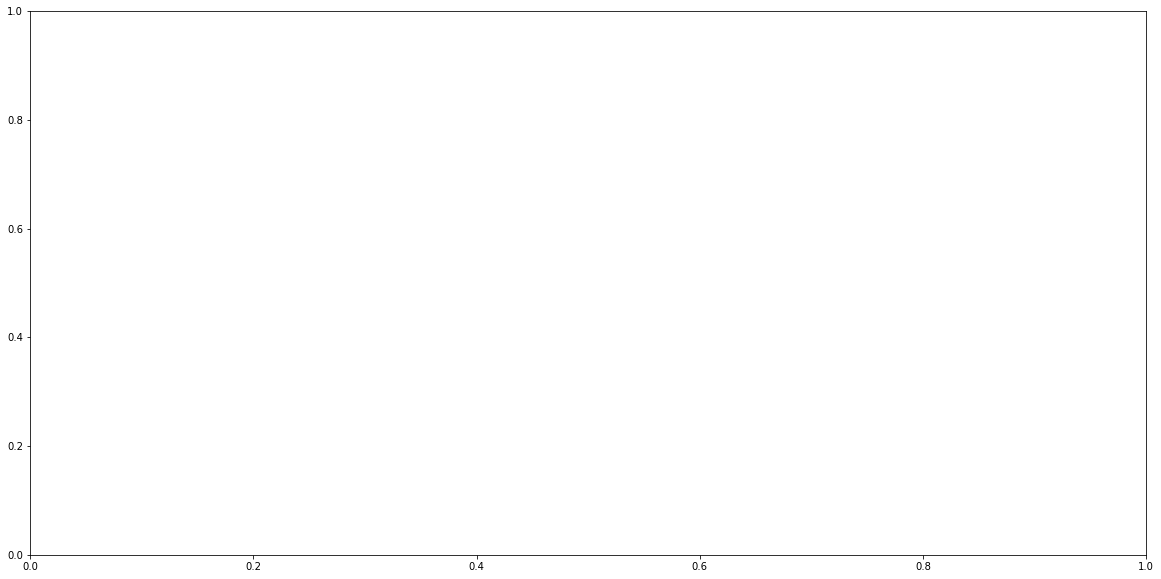

In [64]:
N = [1,2,4,8,16,32]
time_secuential = [0.004480, 0.011200, 0.050400, 0.186400, 0.532160, 0.526080, 3.874560, 4.172800 ,4.177920 ,4.188160, 3.379200]
#time_secuential = [1.102950,  1.282140,  1.464412,  1.876613,  2.856960,  6.759979] 
time_parallel = []

plt.figure(figsize=(20,10))
plt.plot(N, time_secuential)
# plt.plot(N, time_parallel)
plt.title("Time Matrix Multiplication")
plt.ylabel("time (ms)")
plt.xlabel("N")
plt.legend(["Secuential", "Parallel"])
plt.show()

#### translate("Knit midi dress with a V-neckline, straps and matching lace detail.<br/><br/>HEIGHT OF MODEL: 177 CM. / 69.6″")
print ("OVERSIZED SHIRT WITH POCKET TRF")